In [21]:
import math 
import string 
import re

import json 

import pandas as pd 
import sqlite3
import spacy
import numpy as np
from rouge import Rouge 
import seaborn as sns
# sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt



nlp = spacy.load('en_core_web_sm')

In [22]:
def read_annotations(task):
    df_ann = pd.read_csv(f'/home/ramprasad.sa/factual_annotation_llm_summaries/annotations/{task}_annotations.csv', keep_default_na=False)
    df_ann_scores = pd.read_csv(f'/home/ramprasad.sa/factual_annotation_llm_summaries/annotations/{task}_annotation_scores.csv', keep_default_na=False)
    return df_ann, df_ann_scores

In [23]:
df_ann_news, df_ann_scores_news = read_annotations('news')
df_ann_billsum, df_ann_scores_billsum = read_annotations('billsum')
df_ann_pubmed, df_ann_scores_pubmed = read_annotations('pubmed')

In [24]:
# df_errors_pubmed

<Figure size 504x360 with 0 Axes>

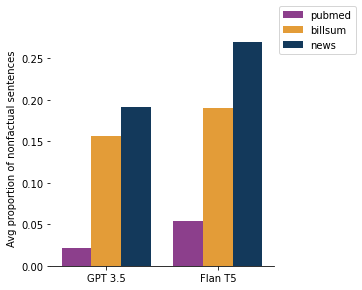

In [25]:
import seaborn as sns
# sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt



def errors_plot(aggregate_score_df):
    clrs = []

    plt.figure(figsize=(7,5))
    ax = sns.catplot(
        
        data=aggregate_score_df,
        kind="bar",
        x="model", y="score", hue="task",
         palette=sns.color_palette([  '#993299', '#ffa11c', '#073a67', ]),
        height= 4,
        legend = None

    )
    sns.despine(bottom = False, left =True)
    ax.set(xlabel='', ylabel='Avg proportion of nonfactual sentences')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.0))
    plt.savefig('prev_errors.pdf', bbox_inches="tight")
    return

def aggregate_scores(df_ann_scores_news, df_ann_scores_billsum, df_ann_scores_pubmed):
    
    df_all_scores = pd.concat([df_ann_scores_news, df_ann_scores_billsum, df_ann_scores_pubmed])

    aggregate_score_df_dict = {'model': [], 'task': [], 'score': []}
    
    for task in list(set(df_all_scores['task'].values)):
        for model in list(set(df_all_scores['model'].values)):
            
            df_task_model = df_all_scores[(df_all_scores['task'] == task) & (df_all_scores['model'] == model)]
            
            score = np.mean(list(df_task_model['score'].values))
            
            aggregate_score_df_dict['model'].append(model)
            aggregate_score_df_dict['task'].append(task)
            aggregate_score_df_dict['score'].append(score)
            
    aggregate_score_df  = pd.DataFrame(aggregate_score_df_dict)     
    aggregate_score_df.sort_values(by=['score'], inplace=True)
    return aggregate_score_df
    
    
aggregate_score_df = aggregate_scores(df_ann_scores_news, df_ann_scores_billsum, df_ann_scores_pubmed)
errors_plot(aggregate_score_df)

0.008264462809917356
set()
0.04285714285714286
set()
0.0297029702970297
set()


<Figure size 504x360 with 0 Axes>

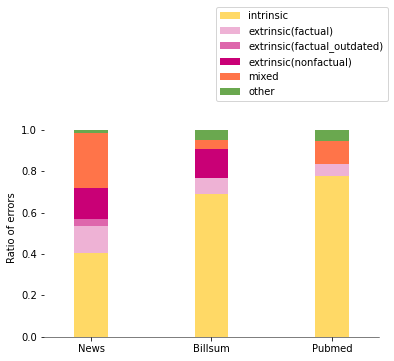

In [26]:
import seaborn as sns
# sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

def make_category_plot(df_cat):
    f = plt.figure(figsize=(7, 5))
    f = plt.figure()
    ax = df_cat.plot(kind='bar', stacked=True,  color = ['#ffd966', '#eeb2d5', '#de66ac', '#c90076', '#ff7449', '#6aa84f'],  
                     ax=f.gca(),width=0.28, rot=0)
    sns.despine(bottom = False, left =True)
    ax.spines['bottom'].set_linewidth(0.5)  # change width
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.3))
    ax.set(xlabel='', ylabel='Ratio of errors')
    plt.savefig('error_categories.pdf', bbox_inches="tight")
    plt.show()

def plot_categories(df_aggrs, tasks):
    
    
    category_aggregate_scores = { 
                                 'intrinsic': [], 
                                 'extrinsic(factual)': [], 
                                 'extrinsic(factual_outdated)': [],
                                 'extrinsic(nonfactual)': [], 
                                 'mixed': [],
                                  'other': [],
                                 
                            
                                }

    for df_aggr, task in list(zip(df_aggrs, tasks)):
        df_aggr_model = df_aggr[(~df_aggr['error_type_ann1'].isnull()) | (~df_aggr['error_type_ann2'].isnull())]
        print(len(df_aggr_model[(df_aggr['error_type_ann1'] == 'other')| (df_aggr['error_type_ann2'] == 'other')])/len(df_aggr_model))
        error_categories = []
        for idx, row in df_aggr_model.iterrows():
            error_category_ann1 = row['error_type_ann1']
            error_category_ann2 = row['error_type_ann2']

            error_factuality_ann1 = row['error_factuality_ann1']
            error_factuality_ann2 = row['error_factuality_ann2']
    
            errors_found = [row['error_type_ann1'], row['error_type_ann2']]
            errors_found = [each for each in errors_found if each.strip() ]
            # print(errors_found)
            
            if len(list(set(errors_found))) > 1:
                error_categories.append('mixed')
                
            elif len(list(set(errors_found))) == 1:
                errors_mapped = []
                if error_category_ann1.strip():
                    if error_factuality_ann1:
                        error_category_ann1 = f'{error_category_ann1}({error_factuality_ann1})'
                    errors_mapped.append(error_category_ann1)
                
                if error_category_ann2.strip() :
                    if error_factuality_ann2:
                        error_category_ann2 = f'{error_category_ann2}({error_factuality_ann2})'
                    errors_mapped.append(error_category_ann2)
                    
                
                error_categories += list(set(errors_mapped))
        
        print(set(error_categories) - set(category_aggregate_scores))
        for category in category_aggregate_scores:
            
            score = error_categories.count(category)/len(error_categories)
            category_aggregate_scores[category].append(score)
        
    category_aggregate_scores['tasks'] = tasks
    # category_aggregate_scores['model'] = df_aggr['system_id'].values
   
    df_cat = pd.DataFrame(category_aggregate_scores, index = tasks)
    make_category_plot(df_cat)

plot_categories([df_ann_news, df_ann_billsum, df_ann_pubmed], ['News', 'Billsum', 'Pubmed' ])